In [2]:
%reload_ext cypher
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
import datetime
import locale
import math 
import re   
import operator
from collections import Counter

In [3]:
def highlight_cells(row):
    color = ''
    if ('Section' in row.index.values and row['Section'] == 'Total') or ('Title' in row.index.values and row['Title'] == 'Total') or ('Months' in row.index.values and (row['Months'] == 'Total' or row['Months'] == 'Average') or ('Terms' in row.index.values and row['Terms'] == 'Total')) :
        color = 'yellow'    
    background = ['background-color: {}'.format(color) for _ in row]
    return background

## Cantidad total de artículos

In [4]:
%cypher MATCH (n:Article) RETURN count(n) as Total

1 rows affected.


Total
2055


## Cantidad de artículos por sección

In [5]:
df = %%cypher MATCH (n:Article) RETURN n.section as Section, count(n.hid) as Number ORDER BY Number DESC
df = df.get_dataframe()
df = df.set_index(['Section'])
df.loc['Total'] = df['Number'].sum()
df = df.reset_index()
df.style.apply(highlight_cells, axis=1)

19 rows affected.


,Section,Number
0,Silla Nacional,431
1,La Silla Caribe,179
2,La Silla Santandereana,170
3,Red de la Educación,159
4,Red de la Paz,158
5,Red Líder,130
6,Red Cachaca,111
7,Opinión,100
8,Red de las Mujeres,94
9,Red Rural,85


## Cantidad de artículos en secciones seleccionadas

In [6]:
%cypher MATCH (n:Article) SET n.valid = False 
%cypher MATCH (n:Article) WHERE n.section = 'Silla Nacional' or n.section ='La Silla Caribe'or n.section = 'La Silla Santandereana'or n.section = 'Red de la Paz'or n.section = 'Opinión'or n.section = 'Red Caribe'or n.section = 'La Silla'or n.section = 'La Silla Pacífico'or n.section = 'Hágame el cruce' SET n.valid = True

2055 properties set.
1010 properties set.


[]

In [7]:
pdf = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.section as Section, count(n.hid) as Number ORDER BY Number DESC
pdf = pdf.get_dataframe() 
pdf = pdf.set_index(['Section'])
pdf.loc['Total'] = pdf['Number'].sum()
pdf = pdf.reset_index()
pdf.style.apply(highlight_cells, axis=1)

7 rows affected.


,Section,Number
0,Silla Nacional,431
1,La Silla Caribe,179
2,La Silla Santandereana,170
3,Opinión,100
4,La Silla,62
5,La Silla Pacífico,43
6,Hágame el cruce,25
7,Total,1010


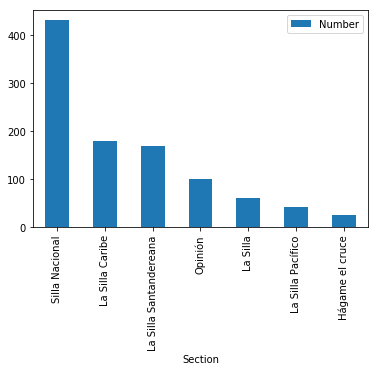

In [8]:
pdf = pdf.drop([7])
pdf.set_index('Section').plot(kind='bar')

## Secciones más visitadas

7 rows affected.


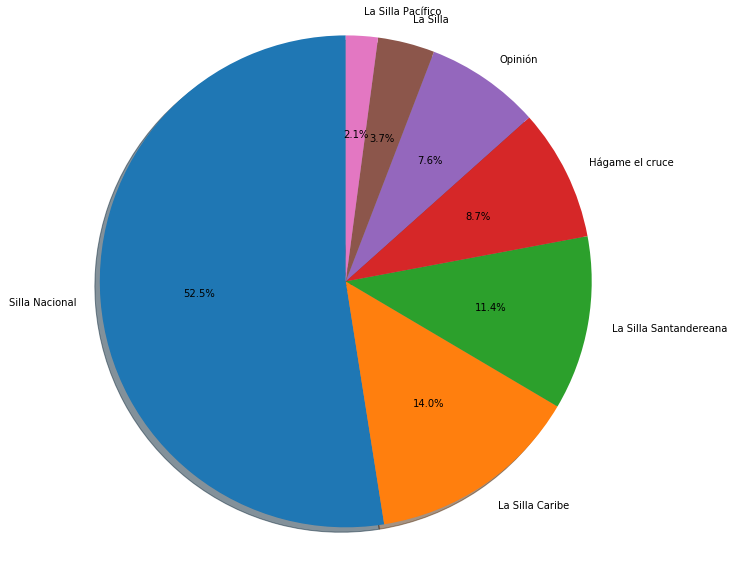

In [9]:
dfV = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.section as Section, sum(toInt(n.no_views)) as Views ORDER BY Views DESC 
dfV = dfV.get_dataframe() 

matplotlib.rcParams['figure.figsize'] = (12.0,10.0)

labels = dfV['Section'].values
sizes = dfV['Views'].values
explode = (0, 0, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [10]:
dfV = dfV.set_index('Section')
dfV.loc['Total'] = sum(int(i) for i in dfV['Views'].values)
dfV['Views'] = dfV['Views'].map('{:,}'.format)
dfV.reset_index().style.apply(highlight_cells, axis=1)

,Section,Views
0,Silla Nacional,"2,637,606"
1,La Silla Caribe,"703,816"
2,La Silla Santandereana,"574,546"
3,Hágame el cruce,"435,114"
4,Opinión,"379,772"
5,La Silla,"187,709"
6,La Silla Pacífico,"105,508"
7,Total,"5,024,071"


## 50 Artículos más visitados

In [11]:
df50 = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.hid as ID, n.title as Title, n.date as Date, n.section as Section, toInt(n.no_views) as Views ORDER BY Views DESC LIMIT 50
df50 = df50.get_dataframe().set_index(['Title'])
df50.loc['Total'] = ['-', '-', '-', df50['Views'].sum()]
df50['Views'] = df50['Views'].map('{:,}'.format)
df50.reset_index().style.apply(highlight_cells, axis=1)

50 rows affected.


,Title,ID,Date,Section,Views
0,¿Vicky inaugura una nueva era del periodismo nacional?,h1312,16 de Febrero de 2016,Silla Nacional,"117,555"
1,Las Farc ha cedido más que el Gobierno en La Habana,h1536,27 de Junio de 2016,Hágame el cruce,"112,805"
2,"""Quiero decirles a los que promocionan la guerra, que no tienen ni idea de lo que es""",h1520,28 de Septiembre de 2016,Silla Nacional,"81,781"
3,"Las propuestas del No, comparadas y desmenuzadas",h1538,15 de Octubre de 2016,Hágame el cruce,"69,711"
4,¿Qué es una ideología de género?,h1638,11 de Agosto de 2016,Opinión,"54,985"
5,Detector de mentiras a Uribe sobre el acuerdo final,h976,28 de Agosto de 2016,Silla Nacional,"38,933"
6,"“¡Quién diría que creer en la PAZ costara tanto!""",h213,22 de Septiembre de 2016,Silla Nacional,"37,551"
7,El 'papayazo' de Gina,h557,11 de Agosto de 2016,Silla Nacional,"37,429"
8,Así son los colombianos de Panamá Papers,h607,15 de Mayo de 2016,Hágame el cruce,"36,682"
9,Vargas Lleras ya no es el candidato a vencer en 2018,h365,03 de Octubre de 2016,Silla Nacional,"34,690"


# Frecuencia de publicaciones

## Cantidad de publicaciones mensuales (Total y Promedio al final)

In [12]:
dfTimes = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.hid as ID, n.date as Date
dfTimes = dfTimes.get_dataframe()
times = dfTimes.Date.apply(lambda x: datetime.datetime.strptime(x.replace('de Enero de', '01').replace('de Febrero de', '02').replace('de Marzo de', '03').replace('de Abril de', '04').replace('de Mayo de', '05').replace('de Junio de', '06').replace('de Julio de', '07').replace('de Agosto de', '08').replace('de Septiembre de', '09').replace('de Octubre de', '10').replace('de Noviembre de', '11').replace('de Diciembre de', '12'), "%d %m %Y"))
dfTimes ['Date'] =  times
dfTimesMensuales = dfTimes.groupby(dfTimes['Date'].dt.month).agg({'ID':'count'})
dfTimesMensuales.loc['Average'] =  math.ceil(dfTimesMensuales['ID'].mean()*100/100)
dfTimesMensuales.loc['Total'] =  dfTimesMensuales.drop(['Average'])['ID'].sum()
dfTimesMensuales.columns = ['Number']
dfTimesMensuales.index.rename('Months', inplace=True)
dfTimesMensuales = dfTimesMensuales.rename({1:'Enero', 2:'Febrero', 3:'Marzo',4:'Abril', 5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})
dfTimesMensuales = dfTimesMensuales.reset_index()
dfTimesMensuales.style.apply(highlight_cells, axis=1)

1010 rows affected.


,Months,Number
0,Enero,63
1,Febrero,74
2,Marzo,44
3,Abril,74
4,Mayo,71
5,Junio,84
6,Julio,77
7,Agosto,93
8,Septiembre,102
9,Octubre,110


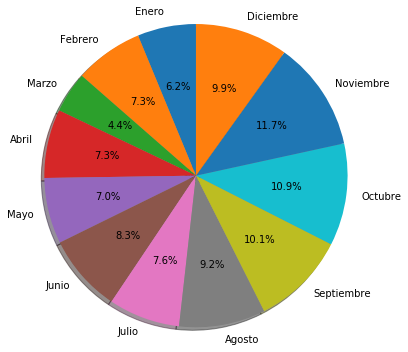

In [13]:
dfTimesMensuales = dfTimesMensuales.drop([12,13])
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)

labels = dfTimesMensuales['Months'].values
sizes = dfTimesMensuales['Number'].values
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## 10 días con mayor cantidad de publicaciones

##### Hay muchos más días con 6 publicaciones , por eso seleccioné solo los 10 primeros ( ver el próximo reporte para la cantidad de días por número de publicaciones)

In [14]:
dfTimesTopDays = dfTimes.groupby(dfTimes['Date']).agg({'ID':'count'})
dfTimesTopDays.columns = ['Cantidad']
dfTimesTopDays = dfTimesTopDays.sort_values(by='Cantidad', ascending=False)
dfTimesTopDays.head(10)

,Cantidad
Date,
2016-10-24,8
2016-09-28,7
2016-11-08,7
2016-11-28,7
2016-10-21,6
2016-12-16,6
2016-12-15,6
2016-06-14,6
2016-12-12,6


## Frecuencia diaria de publicaciones 

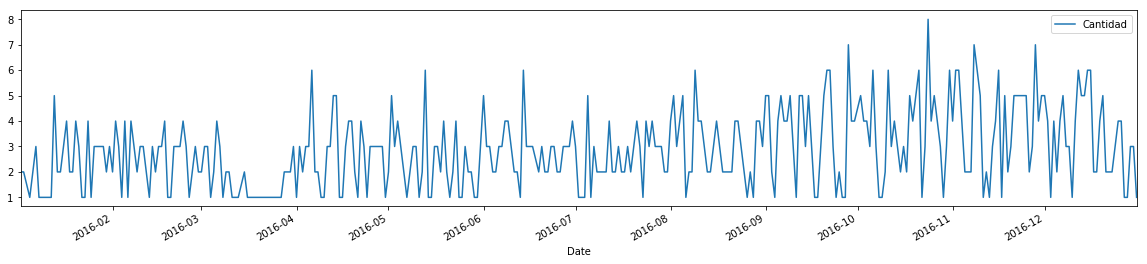

In [15]:
matplotlib.rcParams['figure.figsize'] = (20.0, 4.0)
dfTimesTopDays.plot()

## Cantidad de días por número de publicaciones

In [16]:
dfDias = dfTimesTopDays.reset_index().groupby(['Cantidad']).agg({'Date':'count'})
dfDias.index.rename('Cantidad de publicaciones', inplace=True)
dfDias.columns= ['Cantidad de días']
dfDias

,Cantidad de días
Cantidad de publicaciones,
1,71
2,82
3,89
4,53
5,33
6,17
7,3
8,1


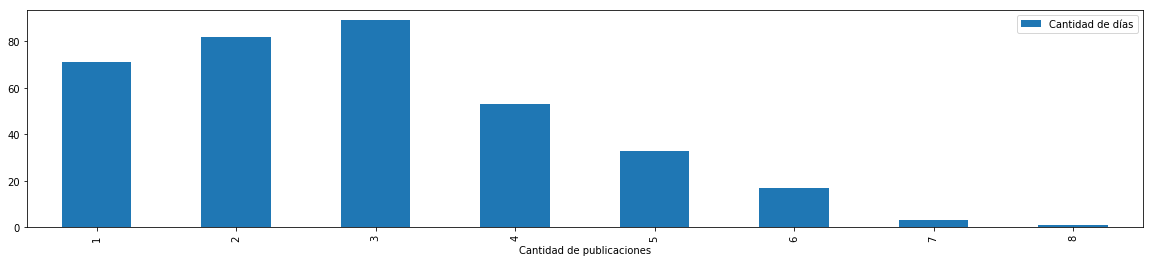

In [17]:
dfDias.plot(kind='bar')

## Promedio de publicaciones diarias

In [18]:
math.ceil(dfTimesTopDays['Cantidad'].mean()*100/100)

3

# Natural Language Processing

In [19]:
from nltk import ngrams
import operator
from itertools import islice
import string 
from tabulate import tabulate

def stopWordsInGrams(grams):    
    count = 0
    for w in grams:
        if w in stop_words_spanish:
            count = count + 1                
    return count/len(grams)  

def isNumber(s):
    try: 
        int(s)
        float(s)
        return True
    except ValueError:
        return False

def getNGram(text, n, stop_words, m):
    text = text.lower()
    ngramas = ngrams(text.split(), n)
    h_dict = {}   
    for grams in ngramas:
        if stopWordsInGrams(grams) > 0.34:
            continue
        words = ' '.join(grams)        
        words = words.lower() 
        words = ''.join(e for e in words if e.isalnum() or e == ' ')    
        words = words.strip()  
        if  words in stop_words or words in punct_signs or words == '' or words in abc or isNumber(words) or len(words.split(' ')) != n:
             continue
        if words in h_dict:
            h_dict[words] = h_dict[words] + 1
        else: 
            h_dict[words] = 1 
    sorted_dict = sorted(h_dict.items(), key=operator.itemgetter(1), reverse=True)
    if m is -1:
        return list(sorted_dict)
    else:
        return list(islice(sorted_dict, m))

In [20]:
stop_words_spanish = ['un', 'una', 'unas', 'unos', 'uno', 'sobre', 'todo', 'también', 'tras', 'otro', 'algún', 'alguno', 'alguna', 'algunos', 'algunas', 'ser', 'es', 'soy', 'eres', 'somos', 'sois', 'estoy', 'esta', 'estamos', 'estais', 'estan', 'como', 'en', 'para', 'atras', 'porque', 'por qué',  'estaba', 'ante', 'antes', 'siendo', 'ambos', 'pero', 'por', 'poder', 'puede', 'puedo', 'podemos', 'podeis', 'pueden', 'fui', 'fue', 'fuimos', 'fueron', 'hacer', 'hago', 'hace', 'hacemos', 'haceis', 'hacen', 'cada', 'fin', 'incluso', 'primero', 'desde', 'conseguir', 'consigo', 'consigue', 'consigues', 'conseguimos', 'consiguen', 'ir', 'voy', 'va', 'vamos', 'vais', 'van', 'vaya', 'gueno', 'ha', 'tener', 'tengo', 'tiene', 'tenemos', 'teneis', 'tienen', 'el', 'la', 'lo', 'las', 'los', 'su', 'aqui', 'mio', 'tuyo', 'ellos', 'ellas', 'nos', 'nosotros', 'vosotros', 'vosotras', 'si', 'dentro', 'solo', 'solamente', 'saber', 'sabes', 'sabe', 'sabemos', 'sabeis', 'saben', 'ultimo', 'largo', 'bastante', 'haces', 'muchos', 'aquellos', 'aquellas', 'sus', 'entonces', 'tiempo', 'verdad', 'verdadero', 'verdadera', 'cierto', 'ciertos', 'cierta', 'ciertas', 'intentar', 'intento', 'intenta', 'intentas', 'intentamos', 'intentais', 'intentan', 'dos', 'bajo', 'arriba', 'encima', 'usar', 'uso', 'usas', 'usa', 'usamos', 'usais', 'usan', 'emplear', 'empleo', 'empleas', 'emplean', 'ampleamos', 'empleais', 'valor', 'muy', 'era', 'eras', 'eramos', 'eran', 'modo', 'bien', 'cual', 'cuando', 'donde', 'mientras', 'quien', 'con', 'entre', 'sin', 'trabajo', 'trabajar', 'trabajas', 'trabaja', 'trabajamos', 'trabajais', 'trabajan', 'podria', 'podrias', 'podriamos', 'podrian', 'podriais', 'yo', 'aquel', 'a', 'en', 'de', 'para', 'por', 'según', 'sin', 'sobre', 'tras', 'bajo', 'contra', 'hacia', 'hasta', 'rt', 'que', 'se', 'no', 'del', 'al', 'http', 'https', 'y', 'más', 'todos', 'año', 'será', 'este', 'vía', 'les', 'ni', 'dice', 'le', 'está', 'qué', 'hay', 'htt', 'quiere', 'nuestra', 'sí', 'of', 'in', 'años', 'firma' , 'firman', 'nuevo', 'hoy', 'ayer', 'inicio', 'ya', 'día','son', 'final', 'and', 'with', 'you', 'mundo', 'gran', 'sol', 'recibe', 'millones',  'gracias', 'hermana', 'fuego', 'me', 'eso',  'we', 'after', 'camino', 'dijo', 'caminos', 'recibirá', 'entiendo', 'mejores', 'mejor', 'deseos', 'lleve', 'nuevamente', 'ahora', 'definitiva', 'ese', 'definitivo', 'han', 'sino', 'tal', 'mismos', 'estos', 'así', 'ver', 'esto', 'esta', 'sido', 'manera', 'sigo', 'da', 'esa', 'aunque', 'están', 'mil', 'además', 'había', 'él', 'después', 'pues', 'vez', 'quienes']

abc = string.ascii_lowercase 
punct_signs = string.punctuation

## Top 20 Unigramas más frecuentes 

In [21]:
dfText = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.text as Text, n.title as Title, n.date as Date
dfText = dfText.get_dataframe()
data = '\n'.join(dfText['Text'].values)
final = getNGram(data, 1, stop_words_spanish, 20)
print(tabulate(final, ['Ngram', 'Number']))

1010 rows affected.
Ngram         Number
----------  --------
silla           3364
gobierno        2848
farc            2762
paz             2328
acuerdo         2101
santos          1606
parte           1592
país            1511
política        1471
presidente      1441
campaña         1430
tres            1390
partido         1280
hecho           1231
estado          1229
otros           1215
proceso         1210
nacional        1180
menos           1171
político        1144


## Top 20 Bigramas más frecuentes

In [22]:
final5 = getNGram(data, 2, stop_words_spanish, 20)
print(tabulate(final5, ['Ngram', 'Number']))

Ngram                    Number
---------------------  --------
cambio radical              371
juan manuel                 367
manuel santos               328
centro democrático          313
vargas lleras               237
álvaro uribe                235
silla caribe                214
corte constitucional        204
estados unidos              183
presidente juan             182
presidente santos           179
semana pasada               176
germán vargas               175
derechos humanos            163
bandas criminales           154
buena parte                 154
ex presidente               150
justicia transicional       138
partido liberal             137
unidad nacional             134


## Cantidad de menciones a Juan Manuel Santos 

##### Se incluye el término 'Santos' también pero es posible que se utilice sin referirse al presidente. Solo se cuenta las veces que aparece en letra inicial mayúscula 

In [23]:
import re
def extract_RegularExpression(text, regExp):
    mentions = []
    patron = re.compile(regExp)
    mentions = patron.findall(text)    
    mentions = [tuple(filter(None, x)) for x in mentions]
    mentions = [x[0] for x in mentions] 
    h_dict = {}
    for x in mentions:
        if x in h_dict:
            h_dict[x] = h_dict[x] + 1
        else:
            h_dict[x] = 1
    result = pd.DataFrame(list(h_dict.items()), columns=['Terms', 'Number'])
    result = result.set_index('Terms')
    result.loc['Total'] = result['Number'].sum()
    return result.reset_index()

In [24]:
santosRegExp = '(([pP]residente[ ]+)*([jJ]uan[ ]+[mM]anuel[ ]+[sS]antos))+|([pP]residente[ ]+[jJ]uan[ ]+[Mm]anuel)+|([pP]residente[ ]+[sS]antos)+|(Santos)+'
santos = extract_RegularExpression(data, santosRegExp)
santos.style.apply(highlight_cells, axis=1)

,Terms,Number
0,Presidente Santos,55
1,Santos,1119
2,Presidente Juan Manuel Santos,18
3,presidente Juan Manuel,1
4,presidente Juan Manuel Santos,162
5,Juan Manuel Santos,146
6,presidente Santos,118
7,Total,1619


## 20  Unigramas más frecuentes en la misma oración que 'Santos'

In [25]:
def getNGramasFrecuencyBySentence(sentences, regExp, term, n, m, lower):
    regexpComp = re.compile(regExp)
    data_term = ''
    for s in sentences: 
        if regexpComp.search(s.lower() if lower == True else s): 
            data_term = data_term + '\n' + s

    stop_words = stop_words_spanish
    stop_words.append(term)
    finalTerm = getNGram(data_term, n,stop_words , m)
    print(tabulate(finalTerm, ['Ngram', 'Number']))

In [26]:
getNGramasFrecuencyBySentence(data.split('.'), r'[\n .,;\'\"]Santos[\n .,;\'\"]', 'santos', 1, 20, False)

Ngram         Number
----------  --------
presidente       430
juan             297
manuel           283
gobierno         279
paz              192
farc             159
acuerdo          154
uribe            127
plebiscito        99
silla             99
campaña           94
país              72
ministro          71
política          68
partido           65
nacional          65
proceso           64
tres              61
ex                59
vargas            57


## Bigramas más frecuentes en la misma oración que 'Santos'

In [27]:
getNGramasFrecuencyBySentence(data.split('.'), r'[\n .,;\'\"]Santos[\n .,;\'\"]', 'santos', 2, 20, False)

Ngram                    Number
---------------------  --------
juan manuel                 278
presidente juan             156
manuel santos                41
segunda vuelta               35
álvaro uribe                 32
presidente santos            23
germán vargas                22
vargas lleras                21
ex presidente                19
unidad nacional              18
gobierno santos              16
reforma tributaria           14
vicepresidente germán        14
cese bilateral               12
corte constitucional         11
cambio radical               11
primera vuelta               11
vuelta presidencial          11
campaña presidencial         10
equipo negociador            10


## Cantidad de menciones a Álvaro Uribe

In [28]:
uribe = extract_RegularExpression(data, '([áÁ]lvaro[ ]+[uU]ribe[ ]+[vV]élez)+|([áÁ]lvaro[ ]+[uU]ribe)+|([uU]ribe)+|([uU]ribe[ ]+[vV]élez)')
uribe.style.apply(highlight_cells, axis=1)

,Terms,Number
0,Álvaro Uribe Vélez,57
1,Uribe,626
2,uribe,6
3,Álvaro Uribe,178
4,Total,867


## Unigramas más frecuentes en la misma oración que 'Uribe'

In [29]:
getNGramasFrecuencyBySentence(data.split('.'), r'[\n .,;\'\"]Uribe[\n .,;\'\"]', 'uribe', 1, 20, False)

Ngram           Number
------------  --------
álvaro             209
presidente         128
gobierno           118
farc               101
ex                  95
acuerdo             93
paz                 82
vélez               63
campaña             54
expresidente        48
centro              43
durante             43
país                41
explicación         40
partido             40
plebiscito          39
democrático         37
parte               37
referendo           35
política            35


## Bigramas más frecuentes en la misma oración que 'Uribe'

In [30]:
getNGramasFrecuencyBySentence(data.split('.'), r'[\n .,;\'\"]Uribe[\n .,;\'\"]', 'uribe', 2, 20, False)

Ngram                     Number
----------------------  --------
ex presidente                 64
álvaro uribe                  46
centro democrático            37
presidente álvaro             33
expresidente álvaro           23
juan manuel                   17
marta lucía                   11
seguridad democrática         10
lucía ramírez                  9
iván duque                     9
iván zuluaga                   8
vélez apresurado               8
óscar iván                     8
apresurado explicación         8
andrés pastrana                8
resistencia civil              7
álvaro leyva                   7
segunda vuelta                 7
debatible explicación          7
presidente uribe               7


## Top 20 Nombres más mencionados

###### Se eliminaron las entradas de Santos e Uribe porque aparece el análisis en celdas anteriores. 

###### En el caso de la palabra paz, se menciona 2328 veces en cualquiera de sus formas (paz, Paz, PAZ, La Paz, etc...) como muestra el reporte anterior de los unigramas. Los números de este reporte significan que 'Paz' (letra inicial mayúscula, sin formar parte de 'La Paz' se mencionó 289 veces y 'La Paz' 65 veces)

In [43]:
file  = open('data/spanish_names.txt', 'r')  
spanish_names = file.readlines()
spanish_names = [s[:-1] for s in spanish_names]

In [44]:
def extractNamesAndEntities(text):
    i = 0
    hdict = {}
    patron = re.compile('(([A-ZÁÉÍÓÚÑÜ]{1}[a-zñáéíóúü]+)([ ]+de[ ]+la[ ]+)?([ ]+de[ ]+)?([ ]+del[ ]+)?([ ]*[A-ZÁÉÍÓÚÑÜ]{1}[a-zñáéíóúü]+)*)')
    names = patron.findall(text)
    names = [x[0] for x in names if x[0].lower() not in stop_words_spanish]
    for k in names:
        k = k.strip()
        for n in spanish_names:            
            if(n is not '' and (n + ' ' in k.upper() or ' ' + n in k.upper() or n == k.upper()) ):       
                if(k in hdict.keys()):
                    hdict[k] = hdict[k] + 1
                else:
                    hdict[k] = 1
                break
    return hdict

def printTopMNames(hdict, m):    
    sorted_dict = sorted(hdict.items(), key=operator.itemgetter(1), reverse=True)
    return list(islice(sorted_dict, m))

In [45]:
hdict = extractNamesAndEntities(data)
final = printTopMNames(hdict, 23)
del final[0]
del final[1]
del final[15]
print(tabulate(final, ['Name', 'Number']))

Name                    Number
--------------------  --------
Álvaro Uribe               169
Rodolfo Hernández          114
Alejandro Ordóñez          104
Clara                       97
Magdalena                   92
Santa Marta                 83
Claudia López               72
San Andrés                  72
Magdalena Medio             71
San José                    67
La Paz                      65
Oneida Pinto                64
Acuerdo de Paz              61
Andrés Pastrana             61
Álvaro Uribe Vélez          57
San Pablo                   54
Juan Fernando Cristo        54
Miguel Ángel Pinto          51
César Gaviria               51
Óscar Iván Zuluaga          50


## Top 20 Unigramas en la misma oración que 'Paz'

##### 'Acuerdo' aparece en plural también, entonces estaría en primera posición con 346 + 145 = 491 apariciones. 

In [31]:
sentences = data.split('.')
regexp = re.compile(r'[ .,;\'\"]paz[ .,;\'\"]')
data_paz = ''
for s in sentences: 
    if regexp.search(s.lower()): 
        data_paz = data_paz + '\n' + s

stop_words = stop_words_spanish
stop_words.append('paz')
final2 = getNGram(data_paz, 1,stop_words , 20)
print(tabulate(final2, ['Ngram', 'Number']))

Ngram           Number
------------  --------
farc               346
acuerdo            340
proceso            281
gobierno           216
acuerdos           145
justicia           123
presidente         108
plebiscito         103
habana              95
silla               94
país                92
especial            92
colombia            82
congreso            77
tribunal            76
jurisdicción        73
política            71
frente              71
guerrilla           70
parte               68


## Top 20 Bigramas en la misma oración que 'Paz'

In [32]:
final2 = getNGram(data_paz, 2,stop_words , 20)
print(tabulate(final2, ['Ngram', 'Number']))

Ngram                           Number
----------------------------  --------
alto comisionado                    46
jurisdicción especial               44
acto legislativo                    37
fast track                          37
sergio jaramillo                    36
juan manuel                         31
justicia especial                   21
circunscripciones especiales        19
justicia transicional               19
conflicto armado                    18
centro democrático                  18
ex presidente                       17
refrendación popular                17
presidente juan                     16
organizaciones sociales             15
san josé                            13
magdalena medio                     13
reforma tributaria                  13
germán vargas                       13
fundación ideas                     12


## Top 20 Unigramas en la misma oración que 'farc'

In [35]:
sentences = data.split('.')
regexp = re.compile(r'[ .,;\'\"]farc[ .,;\'\"]')
data_farc = ''
for s in sentences: 
    if regexp.search(s.lower()): 
        data_farc = data_farc + '\n' + s

stop_words = stop_words_spanish
stop_words.append('farc')
final8 = getNGram(data_farc, 1,stop_words , 20)
print(tabulate(final8, ['Ngram', 'Number']))

Ngram           Number
------------  --------
acuerdo            485
gobierno           386
guerrilla          192
proceso            165
eln                162
silla              154
acuerdos           143
armas              137
víctimas           131
zonas              131
parte              126
habana             126
política           126
negociación        121
país               113
frente             108
presidente         103
plebiscito         100
guerrilleros        98
zona                96


## Top 20 Bigramas en la misma oración que 'farc'

In [36]:
final9 = getNGram(data_farc, 2,stop_words , 20)
print(tabulate(final9, ['Ngram', 'Number']))

Ngram                      Number
-----------------------  --------
bandas criminales              35
juan manuel                    31
centro democrático             30
partido político               26
seis meses                     25
cese bilateral                 22
conflicto armado               22
presidente juan                21
quién cedió                    18
cedió más                      18
grupo armado                   17
justicia transicional          17
caño indio                     16
ex presidente                  16
otros grupos                   16
acuerdo final                  15
iván márquez                   14
cese unilateral                14
equipo negociador              13
organizaciones sociales        13


## Top 20 Unigramas en la misma oración que 'Estado'

In [37]:
sentences = data.split('.')
regexp = re.compile(r'[ .,;\'\"]estado[ .,;\'\"]')
data_estado = ''
for s in sentences: 
    if regexp.search(s.lower()): 
        data_estado = data_estado + '\n' + s

stop_words = stop_words_spanish
stop_words.append('estado')
final3 = getNGram(data_estado, 1,stop_words , 20)
print(tabulate(final3, ['Ngram', 'Number']))

Ngram           Number
------------  --------
consejo            166
silla               61
parte               60
gobierno            58
proceso             53
país                50
política            48
acuerdo             46
menos               39
otros               37
presidente          36
víctimas            35
tres                35
fallo               34
decisión            33
partido             33
caso                33
colombiano          32
guerrilleros        32
guerra              32


## Top 20 Bigramas en la misma oración que 'Estado'

In [38]:
final4 = getNGram(data_estado, 2,stop_words , 20)
print(tabulate(final4, ['Ngram', 'Number']))

Ngram                        Number
-------------------------  --------
alejandro ordóñez                13
corte constitucional             13
estados unidos                   10
centro democrático               10
juan manuel                      10
bandas criminales                10
william villamizar                9
justicia transicional             9
conflicto armado                  9
oneida pinto                      8
derechos humanos                  8
organizaciones criminales         7
sociedad civil                    7
cambio radical                    7
corte suprema                     6
buena parte                       6
presidente juan                   6
contrato social                   6
sala plena                        6
semana pasada                     6


## Top 20 Fechas más mencionadas

In [39]:
def store_dates(regExp, text, datesDict):
    patron = re.compile(regExp)
    for m in patron.finditer(text):
        if m.group() in datesDict:
            datesDict[m.group()].append(m.start())
        else:
            datesDict[m.group()] = [m.start()]    
    return datesDict

def extract_dates(text, datesDict):
    regExp1 = '((primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1})) de (enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre|([0-9]{2}|[1-9]{1})) de ((mil|dos mil) (cien|doscientos|trescientos|cuatrocientos|quinientos|seiscientos|setecientos|ochocientos|novecientos)( dieci| veinti| treinta y| cuarenta y| cincuenta y| sesenta y| setenta y| ochenta y| noventa y)?( )?(uno|dos|tres|cuatro|cinco|seis|séis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince)|[0-9]{4}))'
    
    regExp2 = '(([0-9]{2}|[1-9]{1})[-/]([0-9]{2}|[1-9]{1})[-/]([0-9]{4}))'   
    
    regExp3 = '((enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre)? (del|de|desde|desde el) (primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1}))( al )(primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1}))( de )?(enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre)?( de )?(((mil|dos mil) (cien|doscientos|trescientos|cuatrocientos|quinientos|seiscientos|setecientos|ochocientos|novecientos)( dieci| veinti| treinta y| cuarenta y| cincuenta y| sesenta y| setenta y| ochenta y| noventa y)?( )?(uno|dos|tres|cuatro|cinco|seis|séis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince))|[0-9]{4})?)'
                         
    regExp4 = '(((pasado|próximo|siguiente)( )+((lunes)|(martes)|(miércoles)|(jueves)|(viernes)|(sábado)|(domingo))( )+(primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1})))|(((lunes)|(martes)|(miércoles)|(jueves)|(viernes)|(sábado)|(domingo))( )+ (pasado|próximo|siguiente|(que( )+viene))))'
    
    regExp5 = '((enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre) (a|hasta) (enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre)( )?(de|del)?( )?(((mil|dos mil) (cien|doscientos|trescientos|cuatrocientos|quinientos|seiscientos|setecientos|ochocientos|novecientos)( dieci| veinti| treinta y| cuarenta y| cincuenta y| sesenta y| setenta y| ochenta y| noventa y)?( )?(uno|dos|tres|cuatro|cinco|seis|séis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince))|([0-9]{4}))?)'
   
    regExp6 = '((((mil|dos mil) (cien|doscientos|trescientos|cuatrocientos|quinientos|seiscientos|setecientos|ochocientos|novecientos)( dieci| veinti| treinta y| cuarenta y| cincuenta y| sesenta y| setenta y| ochenta y| noventa y)?( )+(uno|dos|tres|cuatro|cinco|seis|séis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince))|([0-9]{4}))( )+(a|al)( )+(((dos mil|mil)( )+(cien|doscientos|trescientos|cuatrocientos|quinientos|seiscientos|setecientos|ochocientos|novecientos)?( )+(dieci| veinti|treinta y|cuarenta y|cincuenta y|sesenta y|setenta y|ochenta y|noventa y)?( )+(uno|dos|tres|cuatro|cinco|seis|séis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince))|([0-9]{4})))'
                         
    regExp7 = '((enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre)( )+(primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1}))( (a)( )(enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre) (primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1})))?)'
    
    regExp8 = '((primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1})) (de) (enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre) (al|hasta|hasta el) (primero|uno|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce|trece|catorce|quince|dieciséis|diecisiete|dieciocho|diecinueve|veinte|veintiuno|vientidos|veintitres|veinticuatro|veinticinco|veintiséis|veintisiete|veintiocho|veintinueve|treinta|treinta y uno|([0-9]{2}|[1-9]{1})) (de) (enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre))'
         
    datesDict = store_dates(regExp1, text, datesDict)
    datesDict = store_dates(regExp2, text, datesDict)
    datesDict = store_dates(regExp3, text, datesDict)
    datesDict = store_dates(regExp4, text, datesDict)
    datesDict = store_dates(regExp5, text, datesDict)
    datesDict = store_dates(regExp6, text, datesDict)
    datesDict = store_dates(regExp7, text, datesDict)
    datesDict = store_dates(regExp8, text, datesDict)
    return datesDict

In [40]:
datesD = {}
for index, row in dfText.iterrows():    
    datesD = extract_dates(row['Text'].lower(), datesD)

In [41]:
newDict = {}
for key, value in datesD.items():
    newDict[key] = len(value)
result = pd.DataFrame(list(newDict.items()), columns=['Dates', 'Number'])
result = result.sort_values(by='Number', ascending=False)
result = result[:20]
result

,Dates,Number
30,10 de abril de 2016,9
82,febrero 16,7
85,18 de febrero de 2016,5
210,del 16 al 19,5
124,19 de diciembre de 2016,5
182,20 de junio de 2013,4
238,14 de julio de 2016,4
237,7 de septiembre de 2016,4
92,1 de septiembre de 2016,4
145,febrero 18,3


## Nombres mencionados cerca de las fechas más mencionadas. 

##### Se tomaron 1000 caracteres hacia atrás y 1000 hacia adelante a partir de la posición de la fecha encontrada. El tamaño de la ventana es de 2000. 

In [46]:
for key, value in datesD.items():
    if key not in result['Dates'].values:
        continue
    for x in value:
        start = 0 if x<1000 else x-1000
        end = len(data)-1 if ((x + 1000) > (len(data)-1)) else (x + 1000)
        windows_data = data[start:end] 
        namesdict = extractNamesAndEntities(windows_data)
    if len(namesdict) > 0: 
        print('\nDate: ', key)
        finalNames = printTopMNames(namesdict, 10)
        print(tabulate(finalNames, ['Name', 'Number']))


Date:  enero a junio 
Name             Number
-------------  --------
En Santa Ana          1
San Pablo             1
Santa Ana             1
San Francisco         1
Gilberto              1

Date:  9 de agosto de 2016
Name         Number
---------  --------
Carlos            2
Santa Ana         2

Date:  2012 a 2015
Name                      Number
----------------------  --------
Carlos                         2
Gilberto                       2
Néstor                         1
Isidro de Jesús Vargas         1
Santa Ana                      1
Néstor Galeano                 1

Date:  febrero 16
Name              Number
--------------  --------
Carlos                 4
Santa Ana              3
Gilberto               2
Néstor Galeano         1

Date:  18 de febrero de 2016
Name         Number
---------  --------
Santa Ana         1

Date:  1 de septiembre de 2016
Name         Number
---------  --------
Santa Ana         1

Date:  31 de marzo de 2016
Name             Number
------------- 